---
<center> <b>NODE2VEC</b></center>

---

Paper: "node2vec: Scalable Feature Learning for Networks", Aditya Grover, Jure Leskovec, https://arxiv.org/pdf/1607.00653.pdf


# Imports 

In [43]:
import numpy as np
import pandas as pd
import time
import random
from scipy.sparse import csr_matrix
import networkx as nx

from tqdm.notebook import tqdm, trange

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# RandomWalkGenerator

In [2]:
class RandomWalkGenerator:
  def __init__(self, g, p, q, l):
    """RandomWalkGeneration

    Generating random walks for feature learning.

    Args: 
    :param g: networkx graph;
    :param p: p parameter;
    :param q: q parameter;
    :param l: length of a sequence.

    """
    # Params
    self.pi = 1/p
    self.qi = 1/q
    self.l  = l 

    E = nx.linalg.graphmatrix.adjacency_matrix(g)

    # In One
    self.A1 = E > 0 
    # In Two
    self.A2 = E @ E > 0

    # Size
    self.n = E.shape[0]

  def generate_walks(self):
    """generate_walks
    
    From all nodes.

    """
    return np.array([self.generate_random_walk(i) for i in range(self.n)])


  def generate_random_walk(self, v):
    """generate_random_walk

    Generates a random walk.

    Args: 
    :param v: starting node index.
    """

    # New Walk
    walk = [None for _ in range(self.l)]

    # Initial Node
    walk[0] = v
    
    # First Step
    walk[1] = np.random.choice(self.A1[v, :].indices)
    
    # Next Steps
    for i in range(2, self.l):

      a1      = self.A1[walk[i-1], :]
      a1_prev = self.A2[walk[i-2], :]
      a2_prev = self.A2[walk[i-2], :]

      prob=np.zeros(self.n)

      # set all weights to one
      prob[a1.indices]=1
      
      # set weight of nodes wchich can be reached from previous only at two steps to qi.
      prob[(a2_prev>a1_prev).multiply(a1).indices]=self.qi
      
      # set weight to previous node to pi
      prob[walk[i-2]]=self.pi

      # normalize probablity
      prob=prob/np.sum(prob)
      
      # go to new node
      walk[i]=np.random.choice(range(self.n), p=prob)

    return np.array(walk)

# DataSet

## Positive Samples

In [3]:
class PositiveSamples(torch.utils.data.Dataset):
  def __init__(self, walks):
    super(PositiveSamples, self).__init__() 

    X = []
    for a in walks:
      X.append(torch.tensor([(a[i], a[j]) for i in range(len(a)) for j in range(i+1, len(a))]))

    self.X = torch.cat(X)
    self.len = self.X.shape[0]

  def __getitem__(self, idx):
    return self.X[idx]
    
  def __len__(self):
    return self.len

In [4]:
def test_positive_samples():
  p = PositiveSamples(walks)
  return p[0], p

## Negative Samples

In [5]:
class NegativeSamples:

  def __init__(self, walks, n):

    self.n = n
    self.p = np.zeros(n)
    for a in walks:
      self.p[a] += 1

    self.p = self.p**(3/4)
    self.p = self.p / self.p.sum()

  def sample(self, n=1):
    return np.random.choice(self.n, n, p=self.p, replace=False)

  def sample_torch(self, v, n):
    return torch.column_stack((
        torch.full((n,), v),
        torch.tensor(self.sample(n))
    ))


In [6]:
def test_negative_samples():
  ns = NegativeSamples(walks, 10)
  print(ns.p)
  print(ns.sample(3))
  print(ns.sample_torch(2,3))
  return ns

# Word2Vec

In [7]:
from torch.nn import init
class Word2Vec(torch.nn.Module):

    def __init__(self, n, dim):
        super(Word2Vec, self).__init__()

        # Parameters 
        self.n = n
        self.dim = dim

        # U and V matrices
        self.U = torch.nn.Embedding(n, dim, sparse=True)
        self.V = torch.nn.Embedding(n, dim, sparse=True)

        init.uniform_(self.U.weight.data, -1/dim, 1/dim)
        init.constant_(self.V.weight.data, 0)

    def forward(self, UV):
        U = self.U(UV[:,0])
        V = self.V(UV[:,1])

        return (U*V).sum(1).clamp(-10,10).sigmoid()

# Example

In [8]:
def erdos_renyi_graph(P):
    assert P.shape[0] == P.shape[1]
    
    net = nx.empty_graph(P.shape[0])
    
    for i in range(P.shape[0]):
        for j in range(P.shape[1]):
            if np.random.uniform() < P[i,j]:
                net.add_edge(i,j)
    return net

In [9]:
def generate_P(PIn, PBe):
    P = np.ones((80,80))*PBe
    for i in range(4):
        P[(i*20):((i+1)*20), (i*20):((i+1)*20)] = PIn
    P[range(80),range(80)] = 0
    return P

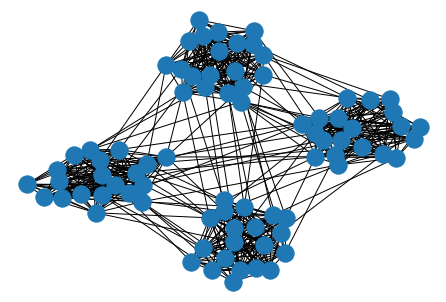

In [10]:
P = generate_P(3/5,3/200)
net = erdos_renyi_graph(P)
nx.draw_spring(net)

In [11]:
net.number_of_nodes()

80

# Training Loop 

In [12]:
rng = RandomWalkGenerator(net, 10, 5, 10)`

In [13]:
n = 80
dim = 3
m = Word2Vec(n, dim)

In [14]:
opt = torch.optim.SparseAdam(m.parameters(), lr=0.01)

In [15]:
EPOCHS = 3
device = 'cpu'

pbar = trange(EPOCHS)
for i in pbar:

    walks = np.vstack([rng.generate_walks() for _ in range(10)])
    pds = PositiveSamples(walks)
    ns = NegativeSamples(walks, 80)
    dl = torch.utils.data.DataLoader(pds, batch_size=5, shuffle=True)

    epoch_loss = 0 
    for p in tqdm(dl): 

      n = torch.vstack([
        ns.sample_torch(i, 4)
        for i in p[:,0]
      ])
      
      p_p = m(p)
      n_p = m(n)

      L = -(p_p.log().sum() + (1-n_p).log().sum())/(p_p.shape[0] + n_p.shape[0])

      m.zero_grad()
      L.backward()
      opt.step()

      pbar.set_description(f"L: {L.item():.03f}")

    # print(epoch_loss)


In [16]:
points = m.U.weight.data

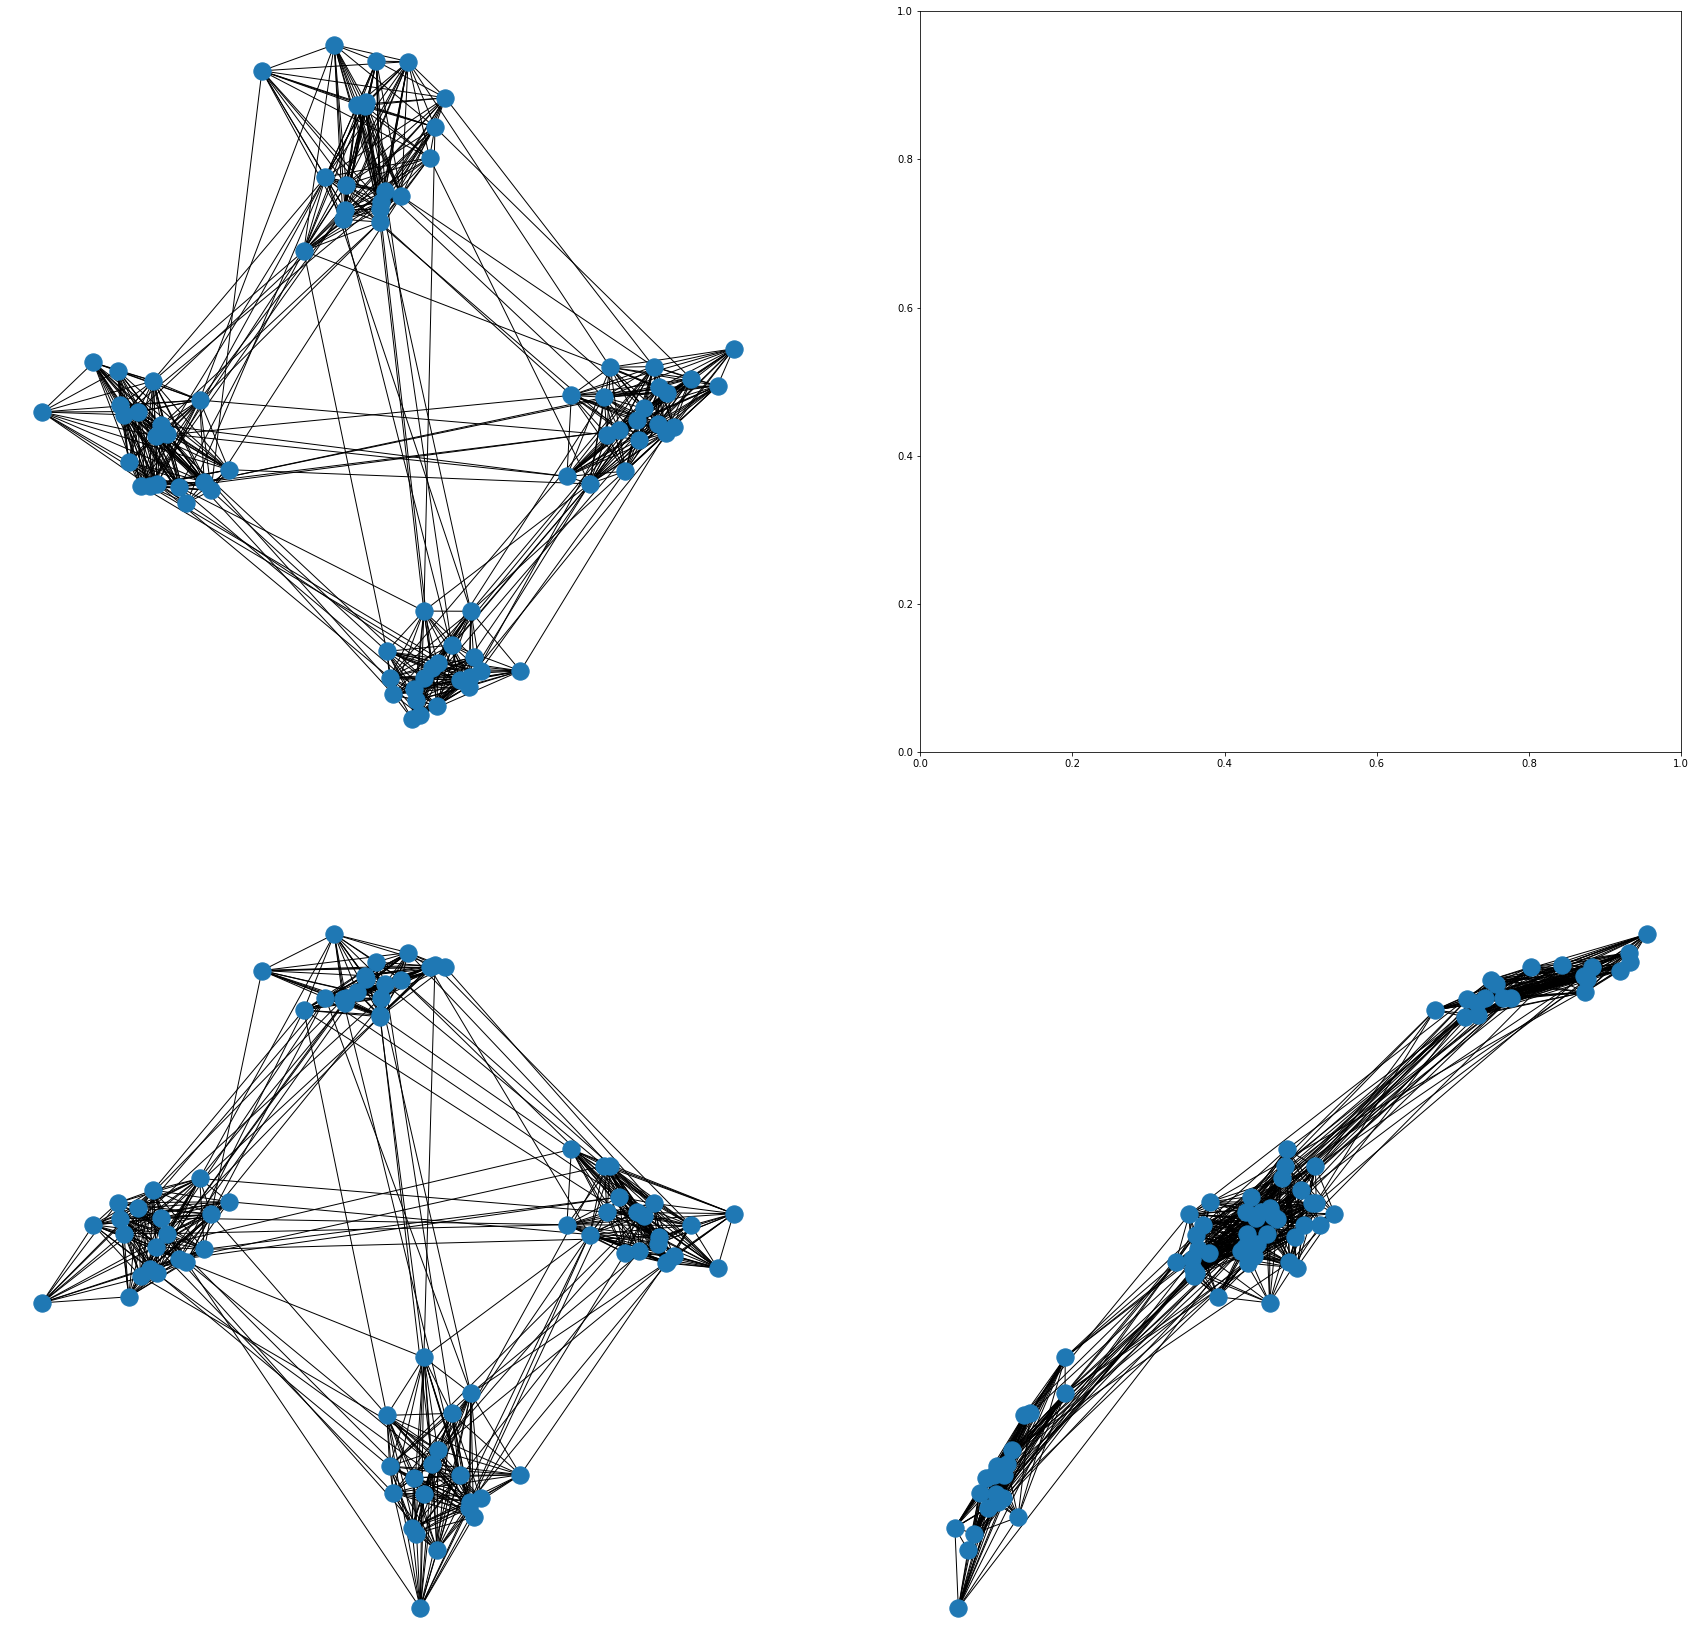

In [17]:
fig, ax = plt.subplots(2,2, figsize=(30,30))
nx.draw(net, pos={
    i: list(points[i].numpy()[[0,1]])
    for i in range(80)
}, ax=ax[0][0])
nx.draw(net, pos={
    i: list(points[i].numpy()[[0,2]])
    for i in range(80)
}, ax=ax[1][0])
nx.draw(net, pos={
    i: list(points[i].numpy()[[1,2]])
    for i in range(80)
}, ax=ax[1][1])

In [18]:
m.U.weight.norm(dim=1)

tensor([1.8986, 1.7582, 2.0041, 1.5762, 1.4804, 1.6642, 1.6567, 1.9665, 1.8610,
        2.1663, 1.3998, 1.4378, 1.9103, 1.7599, 2.2000, 1.5941, 1.8878, 1.5613,
        1.8349, 1.7059, 1.5653, 1.3692, 1.7542, 1.7648, 1.5989, 1.4174, 1.8954,
        2.0921, 1.9507, 1.7128, 1.8993, 1.7091, 1.8031, 1.9413, 1.6391, 1.8156,
        1.7820, 1.5415, 1.7735, 2.3437, 1.8718, 2.1292, 2.3805, 1.6236, 2.3473,
        2.1230, 1.7143, 1.7644, 1.6968, 2.2873, 1.7426, 1.9198, 2.2862, 2.0390,
        2.1186, 1.7848, 2.1549, 1.6664, 1.7321, 1.8248, 1.8744, 1.9338, 2.4579,
        1.8162, 2.1095, 1.6676, 1.9858, 2.0403, 2.1523, 1.4470, 1.9982, 1.9241,
        2.0472, 1.8712, 2.0732, 1.6781, 2.2271, 2.1345, 1.6250, 1.9887],
       grad_fn=<CopyBackwards>)

# Simple K-Means Demo  

In [19]:
class KMeans:
  def __init__(self, X, k, normalize=True):
      self.k = k
      self.X = X
      self.vX = (X*X).sum(1).sqrt()
      self.C = X[np.random.choice(X.shape[0], k, replace=False)].unsqueeze(1)
      self.normalize = normalize
  def vC(self):
      return (self.C*self.C).sum(2).sqrt()
  def predict(self):
      if self.normalize:
        return (self.X*self.C).sum(2).div(self.vX*self.vC()).argmax(0)
      else:
        return (self.X*self.C).sum(2).argmax(0)
  def step(self):
    c = self.predict()
    cs = []
    for k in range(self.k):
      if self.normalize:
        x = self.X[c==k]
        ck = x.mean(0).nan_to_num()
        ck /= ck.norm().clip(0.001)
        ck *= x.norm(dim=1).mean().nan_to_num()
        cs.append(ck)
      else:
        cs.append(self.X[c==k].mean(0))

    self.C = torch.vstack(cs).unsqueeze(1)
  
  def run(self, n):
    for _ in range(n):
      self.step()
    

In [20]:
kmeans = KMeans(m.U.weight.data, 4)

In [21]:
kmeans.run(100)

In [22]:
kmeans.C

tensor([[[ 0.7933,  0.4926, -1.6079]],

        [[-0.1575,  1.9523,  0.0813]],

        [[-1.1801,  0.7176, -1.0291]],

        [[-1.2986,  0.9971, -0.8343]]])

In [24]:
kmeans.predict()

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, 2, 2,
        2, 2, 3, 3, 3, 3, 3, 2, 3, 2, 2, 2, 3, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

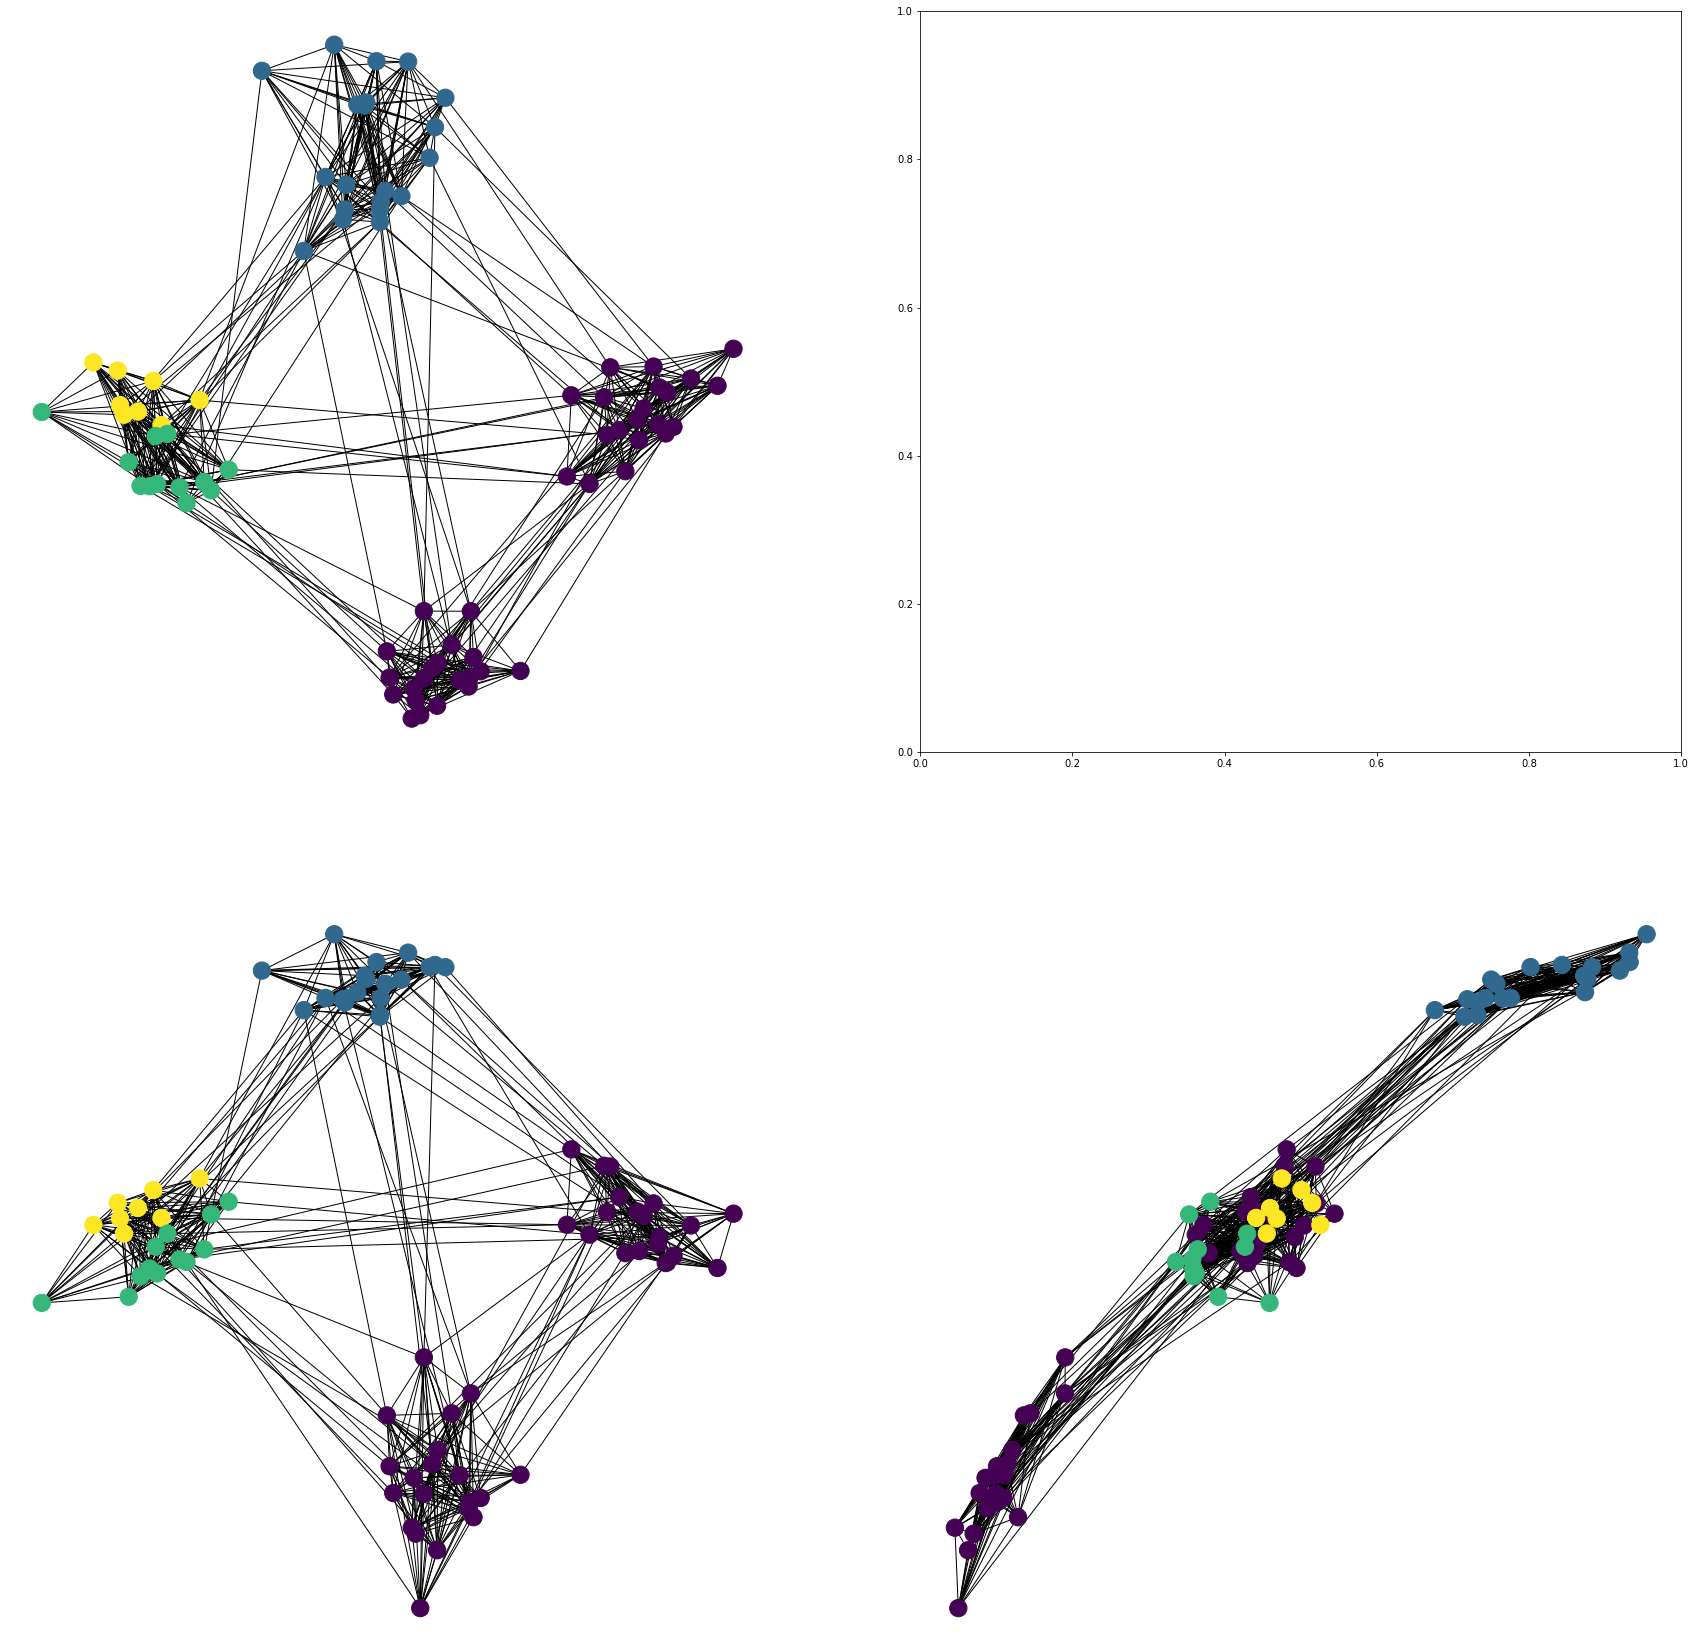

In [23]:
fig, ax = plt.subplots(2,2, figsize=(30,30))
nx.draw(net, pos={
    i: list(points[i].numpy()[[0,1]])
    for i in range(80)
}, ax=ax[0][0], node_color=list(kmeans.predict().numpy()))
nx.draw(net, pos={
    i: list(points[i].numpy()[[0,2]])
    for i in range(80)
}, ax=ax[1][0], node_color=list(kmeans.predict().numpy()))
nx.draw(net, pos={
    i: list(points[i].numpy()[[1,2]])
    for i in range(80)
}, ax=ax[1][1], node_color=list(kmeans.predict().numpy()))

# All in one function

In [29]:
def Node2Vec(G, p, q, l, k):
    """Node2Vec

    Generate communities for Graph.

    Args: 
    :param G: networkx graph;
    :param p: p parameter;
    :param q: q parameter;
    :param l: length of a sequence.
    :param k: number of communities.

    """
    
    rng = RandomWalkGenerator(G, p, q, l)

    n_g = len(G.nodes)
    dim = 3
    m = Word2Vec(n_g, dim)

    opt = torch.optim.SparseAdam(m.parameters(), lr=0.01)
    
    
    EPOCHS = 3
    DIFF_WALKS=10
    device = 'cpu'

    pbar = trange(EPOCHS)
    for i in pbar:

        walks = np.vstack([rng.generate_walks() for _ in range(DIFF_WALKS)])
        pds = PositiveSamples(walks)
        ns = NegativeSamples(walks, n_g)
        dl = torch.utils.data.DataLoader(pds, batch_size=5, shuffle=True)

        epoch_loss = 0 
        for p in tqdm(dl): 

            n = torch.vstack([
            ns.sample_torch(i, 4)
            for i in p[:,0]
          ])

            p_p = m(p)
            n_p = m(n)

            L = -(p_p.log().sum() + (1-n_p).log().sum())/(p_p.shape[0] + n_p.shape[0])

            m.zero_grad()
            L.backward()
            opt.step()

            pbar.set_description(f"L: {L.item():.03f}")

    points = m.U.weight.data       
    kmeans = KMeans(points, k)
    kmeans.run(100)
    return kmeans.predict().numpy()+1

In [27]:
len(net.nodes)

80

In [30]:
Node2Vec(net, p=10, q=5, l=10, k=4)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

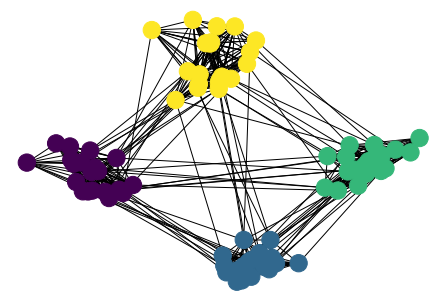

In [55]:
nx.draw(net, pos={
    i: list(points[i].numpy()[[0,1]])
    for i in range(80)
}, node_color=list(np.array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])))

# D1

In [39]:
d1 = pd.read_csv('D1-K=2.csv', header=None).to_numpy()

array([[0, 1, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 1, 0]])

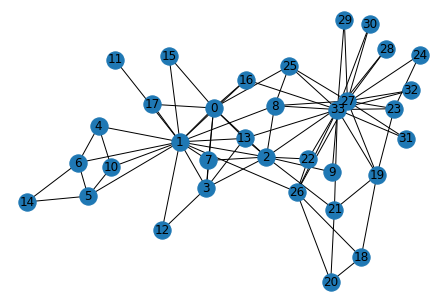

In [42]:
D1 = nx.convert_matrix.from_numpy_matrix(d1)
pos = nx.drawing.layout.spring_layout(D1)
nx.draw(D1, pos=pos, with_labels=True)

In [46]:
start_time = time.time()
comm = Node2Vec(D1, p=10, q=5, l=10, k=2)
total_time=time.time() - start_time

In [51]:
print('total time:', total_time)

df=pd.DataFrame({"node":np.arange(len(D1.nodes))+1,"comm":comm})

df.to_csv("Olaf_Werner_Bogdan_Jastrzebski/D1-K=2.csv",header=False,index=False)

total time: 44.07469940185547


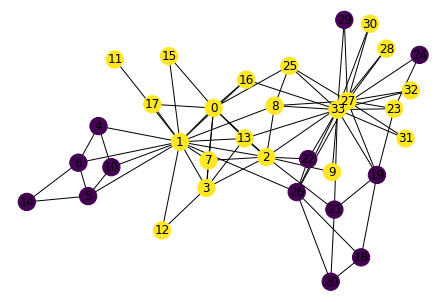

In [54]:
nx.draw(D1, pos=pos, node_color=list(comm),with_labels=True)